### Load fastai library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

##### Labels of the data set
- 'buildings' -> 0, 
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 

##### Define path object and extract zip file 

In [2]:
#Extract zip file
path = Path('data/intel scene/')
#import patoolib  #uncomment this if running for 1st time
#patoolib.extract_archive("data/intel scene/train-scene classification.zip",outdir=path) #uncomment this if running for 1st time

In [3]:
path.ls() # let's see what's inside the path

[PosixPath('data/intel scene/train'),
 PosixPath('data/intel scene/submission8.csv'),
 PosixPath('data/intel scene/labels.csv'),
 PosixPath('data/intel scene/.ipynb_checkpoints'),
 PosixPath('data/intel scene/submission1.csv'),
 PosixPath('data/intel scene/submission7.csv'),
 PosixPath('data/intel scene/submission3.csv'),
 PosixPath('data/intel scene/test'),
 PosixPath('data/intel scene/submission2.csv'),
 PosixPath('data/intel scene/sample_submission.csv'),
 PosixPath('data/intel scene/submission5.csv'),
 PosixPath('data/intel scene/test.csv'),
 PosixPath('data/intel scene/models'),
 PosixPath('data/intel scene/submission9.csv'),
 PosixPath('data/intel scene/submission4.csv'),
 PosixPath('data/intel scene/submission6.csv')]

##### Read the csv files 

In [4]:
labels = pd.read_csv('data/intel scene/labels.csv')  # renmaed the train.csv to labels.csv
test = pd.read_csv('data/intel scene/test.csv')
submit = pd.read_csv('data/intel scene/sample_submission.csv')

In [5]:
labels.shape, test.shape

((17034, 2), (7301, 1))

In [6]:
labels.head()

image_name  label
0      0.jpg      0
1      1.jpg      4
2      2.jpg      5
3      4.jpg      0
4      7.jpg      4

In [7]:
test.head()

image_name
0      3.jpg
1      5.jpg
2      6.jpg
3     11.jpg
4     14.jpg

This particular problem has all the training and test images are in train folder. so we need to first cfreate one test folder (i have done manually) and tranfer the test images to that folder using the test.csv file information. This should be run at first time of executing the notebook. 

In [48]:
# import os
# import shutil
# src = 'data/intel scene/train'
# dst = 'data/intel scene/test'
# for i in range(test.shape[0]):
#     srcpath = os.path.join(src, test['image_name'][i])
#     dstpath = os.path.join(dst, test['image_name'][i])
#     shutil.copyfile(srcpath, dstpath)

Let's now create a fastai imagedatabunch object with some transformation 'tfms'

i have chosen 20% validation set with image size 128. 

In [26]:
np.random.seed(42)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',valid_pct=0.2,size=128 ,ds_tfms=tfms,test = 'test')

In [27]:
data.train_ds.process()

LabelList
y: CategoryList (13628 items)
[Category 4, Category 5, Category 4, Category 1, Category 5]...
Path: data/intel scene
x: ImageItemList (13628 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene

In [18]:
##This is for testing ( Do NOT RUN)
# data = (ImageFileList.from_csv(path, 'labels.csv', folder='train')
#         #Where to find the data? -> in planet 'train' folder
#         .split_by_rand_pct()
#         #How to split in train/valid? -> randomly with the default 20% in valid
#         #.label_from_df(label_delim=' ')
#         #How to label? -> use the second column of the csv file and split the tags by ' '
#         .transform(tfms, size=128)
#         #Data augmentation? -> use tfms with a size of 128
#         .databunch())                          
#         #Finally -> use the defaults for conversion to databunch

## View data

Let's grab few images from our imagedata bunch

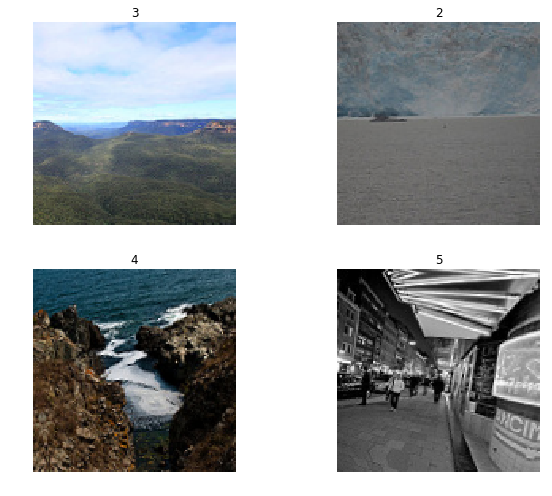

In [19]:
data.show_batch(rows=2, figsize=(9,7))

In [20]:
#doc(ImageImageList)

In [21]:
## Testing (NOT RUN)
# np.random.seed(42)
# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [22]:
data.classes

[0, 1, 2, 3, 4, 5]

we have 6 classes as mentioned before

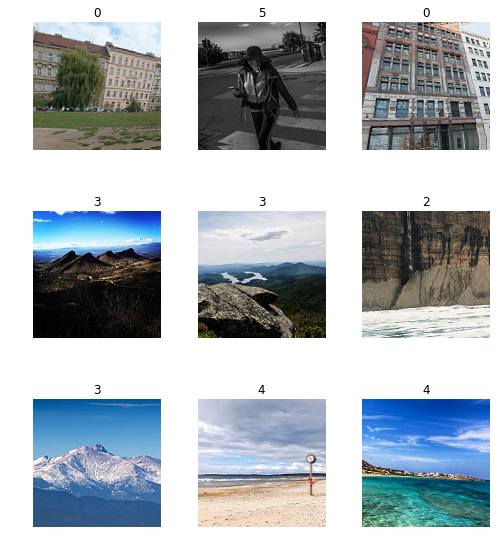

In [23]:
data.show_batch(rows=3, figsize=(7,8))

In [24]:
data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(6, 13628, 3406, 7301)

our length of training and validation set seems reasonable. let's get startedwith training the model

## Train model

fastai has create_cnn (or convulational neural network) function which takes image databunch object and one architecture (here resnet50), also we pass metric as accuracy as given in the problem statement

In [26]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [27]:
learn.fit_one_cycle(4)

wow!! our initial model has nearly 93% accurate. we could have taken few more cycle length (or epoch) to see if we can get any better!!. Let's save our model

In [28]:
learn.save('stage-1')

In [29]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


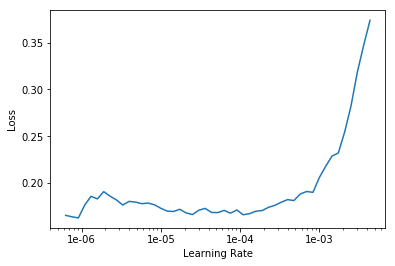

In [49]:
learn.recorder.plot()

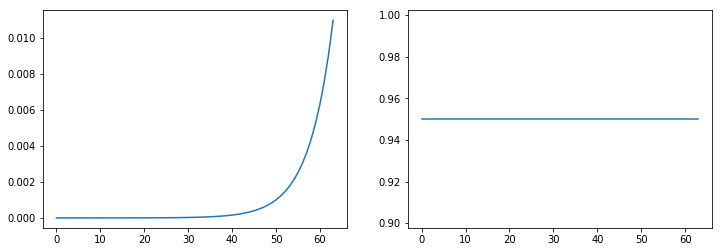

In [51]:
learn.recorder.plot_lr(show_moms=True)

In [36]:
learn.fit_one_cycle(4, max_lr=slice(3e-7,1e-4))

In [37]:
learn.save('stage-2')

## Interpretation

In [5]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (19012 items)
[Category Water Moccasin, Category Water Moccasin, Category Water Moccasin, Category Water Moccasin, Category Water Moccasin]...
Path: data/Snakes
x: ImageItemList (19012 items)
[Image (3, 4299, 6442), Image (3, 525, 700), Image (3, 160, 686), Image (3, 2448, 3264), Image (3, 240, 400)]...
Path: data/Snakes;

Valid: LabelList
y: CategoryList (4753 items)
[Category Yellow-bellied Sea Snake, Category Grey-banded Kingsnake, Category Grey-banded Kingsnake, Category The African Rock Python, Category Anaconda]...
Path: data/Snakes
x: ImageItemList (4753 items)
[Image (3, 368, 640), Image (3, 408, 612), Image (3, 400, 600), Image (3, 466, 700), Image (3, 374, 665)]...
Path: data/Snakes;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

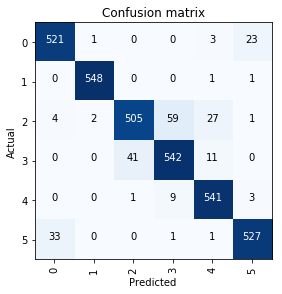

In [39]:
interp.plot_confusion_matrix()

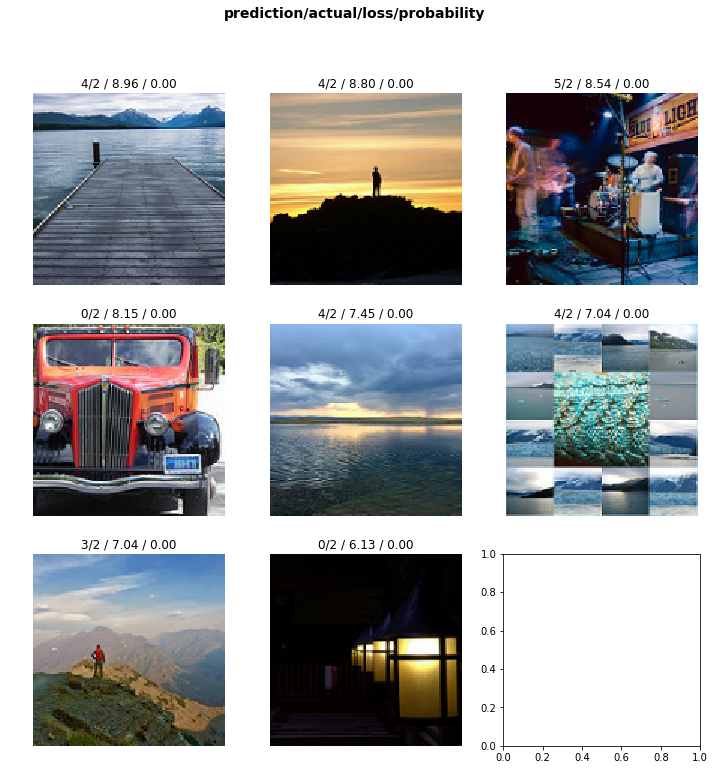

In [40]:
interp.plot_top_losses(8)

In [62]:
#??learn.predict

In [85]:
#learn.predict(data.test_ds)

(Category 2,
 tensor(2),
 tensor([5.4891e-07, 1.1922e-06, 9.9649e-01, 2.7551e-03, 7.4996e-04, 1.2487e-06]))

In [86]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [118]:
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]

In [126]:
labelled_preds = np.array(labelled_preds)

In [127]:
labelled_preds

array([3, 5, 3, 1, ..., 2, 4, 2, 2])

In [136]:
fnames = [f.name for f in learn.data.test_ds.items]

In [148]:
df = pd.DataFrame({'image_name':fnames, 'label':labelled_preds}, columns=['image_name', 'label'])

In [149]:
df.head()

image_name  label
0   7273.jpg      3
1   4584.jpg      5
2  18562.jpg      3
3  10755.jpg      1
4  11715.jpg      5

In [150]:
df.shape, test.shape

((7301, 2), (7301, 1))

In [151]:
df.to_csv(path/'submission1.csv', index=False)

In [158]:
np.random.seed(42)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',valid_pct=0.2,size=256, ds_tfms=tfms,test = 'test')      

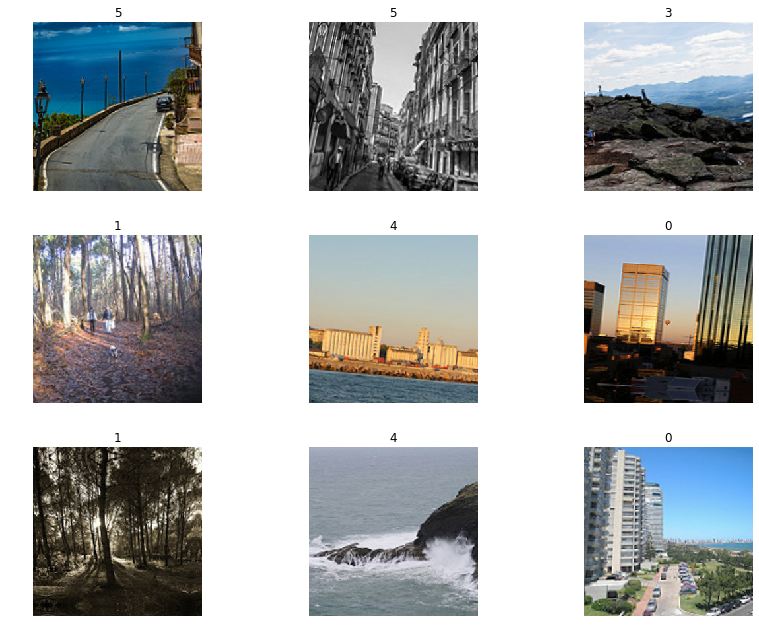

In [159]:
data.show_batch(rows=3, figsize=(12,9))

In [160]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(3)

In [161]:
learn.save('stage-1-256')

In [162]:
learn.unfreeze()

In [163]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


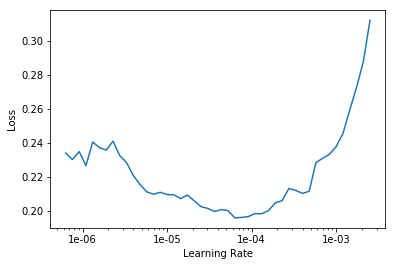

In [164]:
learn.recorder.plot()

In [165]:
learn.fit_one_cycle(3, max_lr=slice(6e-6,3e-4))

In [166]:
learn.save('stage-2-256')

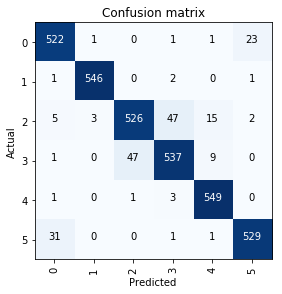

In [167]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

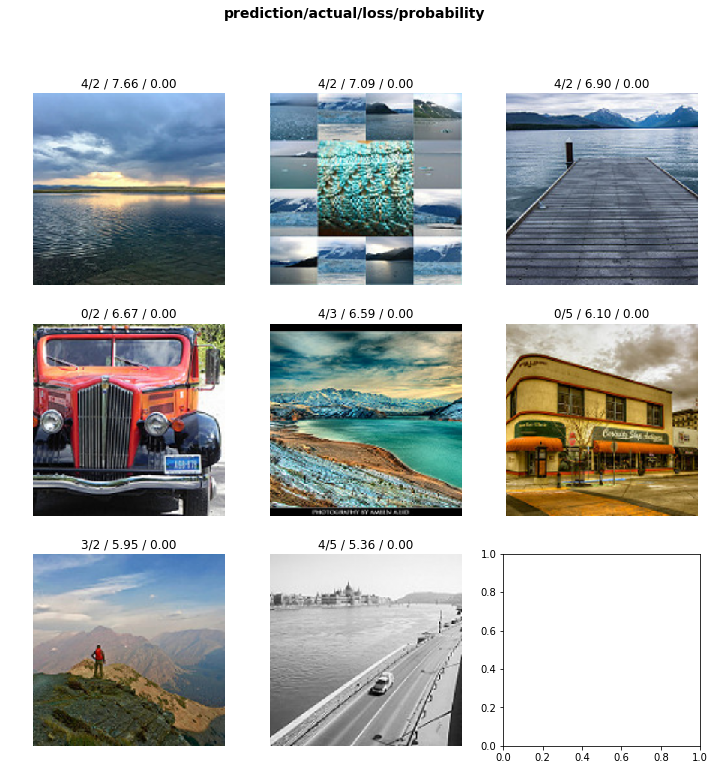

In [168]:
interp.plot_top_losses(8)

In [169]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = np.array([np.argmax(preds[i]) for i in range(len(preds))])
fnames = [f.name for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'label':labelled_preds}, columns=['image_name', 'label'])
df.shape, test.shape

((7301, 2), (7301, 1))

In [170]:
df.to_csv(path/'submission2.csv', index=False)

In [171]:
np.random.seed(42)
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',valid_pct=0.2,size=256, ds_tfms=tfms,test = 'test')  

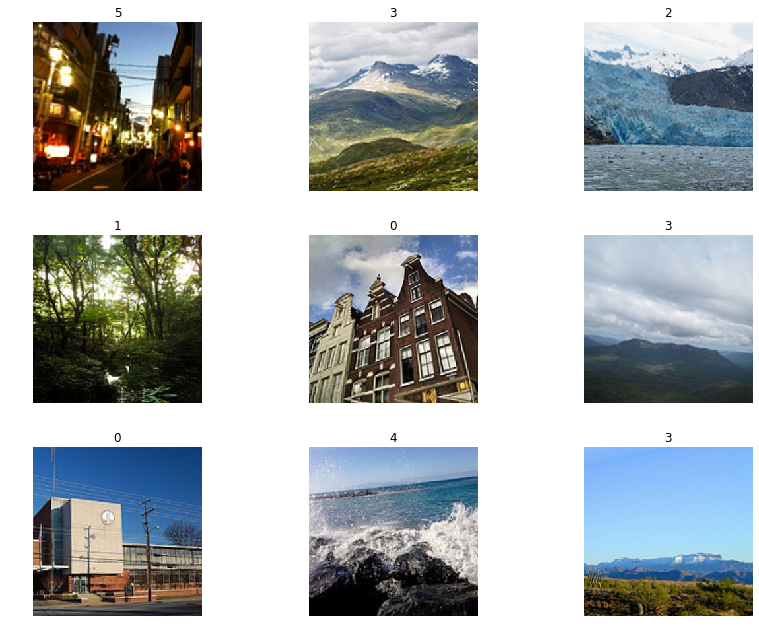

In [172]:
data.show_batch(rows=3, figsize=(12,9))

In [173]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(4)

In [174]:
learn.save('stage-1-256-flip')

In [175]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


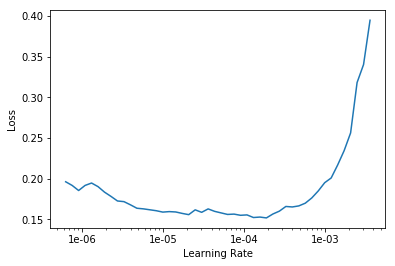

In [176]:
learn.lr_find()
learn.recorder.plot()

In [177]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,3e-4))

In [178]:
learn.save('stage-2-256-flip')

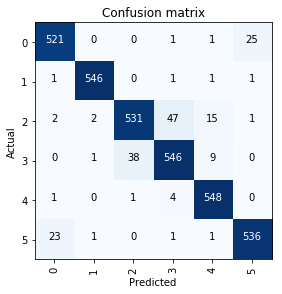

In [179]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

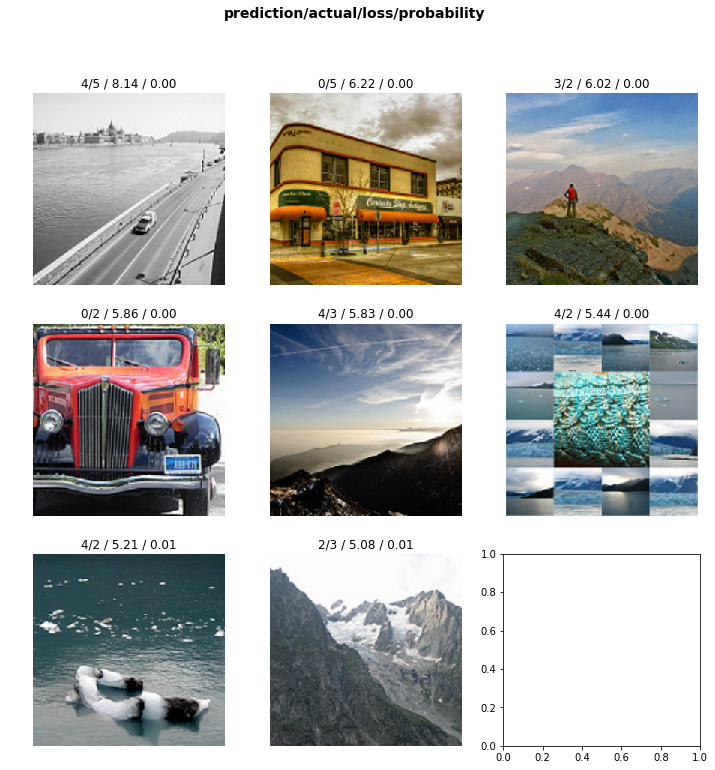

In [180]:
interp.plot_top_losses(8)

In [181]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = np.array([np.argmax(preds[i]) for i in range(len(preds))])
fnames = [f.name for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'label':labelled_preds}, columns=['image_name', 'label'])
df.shape, test.shape

((7301, 2), (7301, 1))

In [182]:
df.to_csv(path/'submission3.csv', index=False)

In [22]:
np.random.seed(42)
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',valid_pct=0.2,size=256, ds_tfms=tfms,test = 'test')  

In [6]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (13628 items)
[Category 4, Category 5, Category 4, Category 1, Category 5]...
Path: data/intel scene
x: ImageItemList (13628 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Valid: LabelList
y: CategoryList (3406 items)
[Category 2, Category 0, Category 0, Category 0, Category 1]...
Path: data/intel scene
x: ImageItemList (3406 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Test: LabelList
y: CategoryList (7301 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: data/intel scene
x: ImageItemList (7301 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene

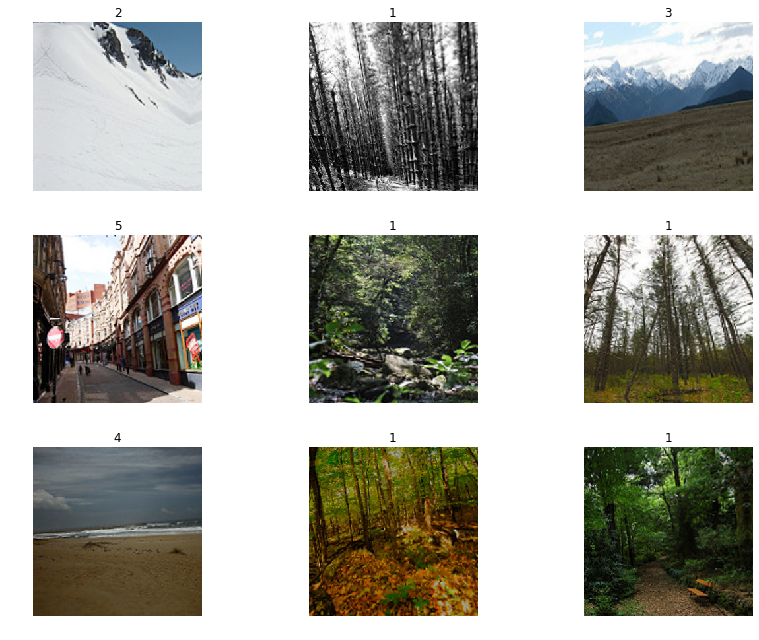

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [8]:
learn = create_cnn(data, models.resnet101, metrics=accuracy)
learn.fit_one_cycle(4)

In [10]:
learn.save('stage-1-256-flip-resnet101')

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


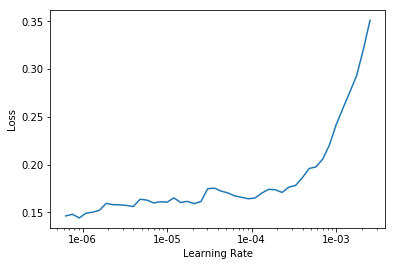

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(4, max_lr=slice(3e-7,1e-4))

In [14]:
learn.save('stage-2-256-flip-resnet101')

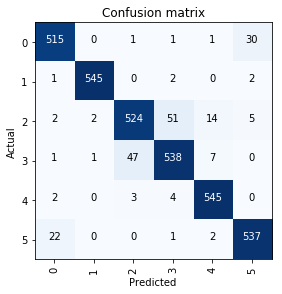

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

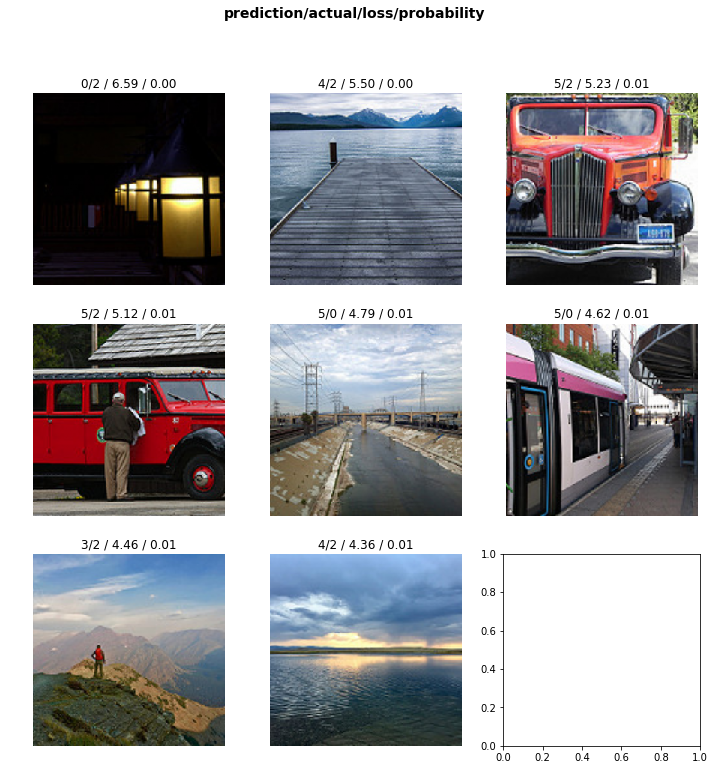

In [16]:
interp.plot_top_losses(8)

In [17]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = np.array([np.argmax(preds[i]) for i in range(len(preds))])
fnames = [f.name for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'label':labelled_preds}, columns=['image_name', 'label'])
df.shape, test.shape

((7301, 2), (7301, 1))

In [19]:
df.to_csv(path/'submission4.csv', index=False)

In [6]:
np.random.seed(42)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',valid_pct=0.001,size=299, ds_tfms=tfms,test = 'test',bs=28)  

In [7]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (17017 items)
[Category 0, Category 4, Category 5, Category 0, Category 4]...
Path: data/intel scene
x: ImageItemList (17017 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Valid: LabelList
y: CategoryList (17 items)
[Category 2, Category 0, Category 0, Category 0, Category 1]...
Path: data/intel scene
x: ImageItemList (17 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Test: LabelList
y: CategoryList (7301 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/intel scene
x: ImageItemList (7301 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene

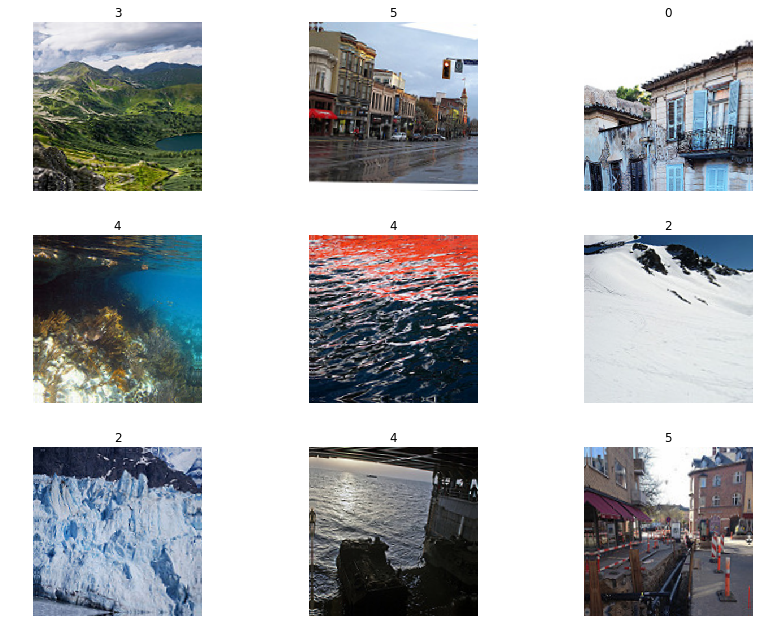

In [10]:
data.show_batch(rows=3, figsize=(12,9))

In [10]:
#learn = create_cnn(data, models.resnet152, metrics=accuracy)
learn.fit_one_cycle(3)

In [9]:
learn.save('stage-1-256-resnet152-norm-bs')

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


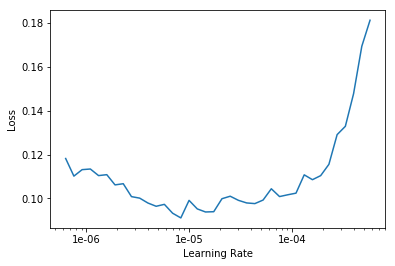

In [26]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.load('stage-1-256-resnet152-norm-bs')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (17017 items)
[Category 0, Category 4, Category 5, Category 0, Category 4]...
Path: data/intel scene
x: ImageItemList (17017 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Valid: LabelList
y: CategoryList (17 items)
[Category 2, Category 0, Category 0, Category 0, Category 1]...
Path: data/intel scene
x: ImageItemList (17 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene;

Test: LabelList
y: CategoryList (7301 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/intel scene
x: ImageItemList (7301 items)
[Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150), Image (3, 150, 150)]...
Path: data/intel scene, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(5e-6,1e-5))

In [16]:
learn.save('stage-2-256-resnet152-norm-bs')

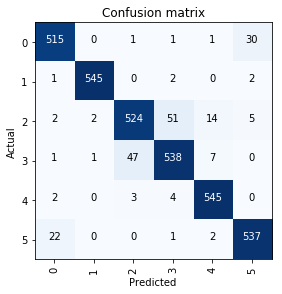

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

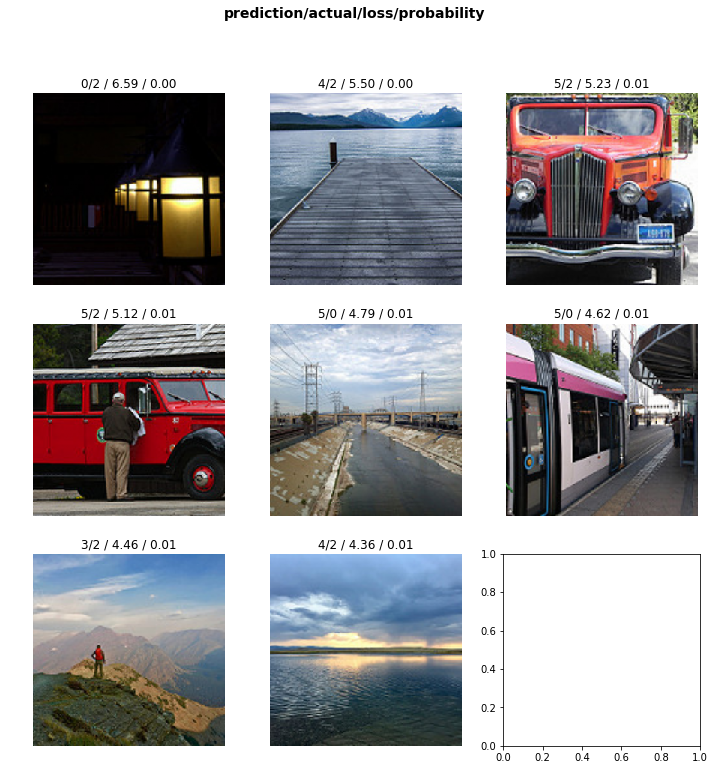

In [16]:
interp.plot_top_losses(8)

In [15]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
labelled_preds = np.array([np.argmax(preds[i]) for i in range(len(preds))])
fnames = [f.name for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'label':labelled_preds}, columns=['image_name', 'label'])
df.shape, test.shape

((7301, 2), (7301, 1))

In [20]:
df.to_csv(path/'submission10.csv', index=False)

In [19]:
learn.TTA(data.test_ds)

TypeError: mul(): argument 'other' (position 1) must be Tensor, not LabelList